In [1]:
import os
import pickle

import numpy as np
import soundfile as sf

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

import torch.nn.functional as F
import librosa
import matplotlib.pyplot as plt

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim):
        super(Encoder, self).__init__()
        self.input_shape = input_shape
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim

        self.conv_layers = nn.ModuleList()
        in_channels = input_shape[0]
        for i in range(len(conv_filters)):
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, conv_filters[i], conv_kernels[i], conv_strides[i], padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(conv_filters[i])
                )
            )
            in_channels = conv_filters[i]

        self.flatten = nn.Flatten()
        self.shape_before_bottleneck = self._calculate_shape_before_bottleneck()
        self.mu = nn.Linear(np.prod(self.shape_before_bottleneck), latent_space_dim)
        self.log_variance = nn.Linear(np.prod(self.shape_before_bottleneck), latent_space_dim)

    def _calculate_shape_before_bottleneck(self):
        sample_data = torch.rand(1, *self.input_shape)
        for layer in self.conv_layers:
            sample_data = layer(sample_data)
        return sample_data.shape[1:]

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        self._shape_before_bottleneck = x.shape[1:]
        x = self.flatten(x)
        mu = self.mu(x)
        log_variance = self.log_variance(x)
        return mu, log_variance

class Decoder(nn.Module):
    def __init__(self, shape_before_bottleneck, conv_filters, conv_kernels, conv_strides, latent_space_dim):
        super(Decoder, self).__init__()
        self.shape_before_bottleneck = shape_before_bottleneck
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim

        self.dense = nn.Linear(latent_space_dim, np.prod(shape_before_bottleneck))
        self.reshape = shape_before_bottleneck

        self.conv_transpose_layers = nn.ModuleList()
        in_channels = conv_filters[-1]
        for i in range(len(conv_filters) - 1, 0, -1):
            stride = conv_strides[i]
            output_padding = 1 if (isinstance(stride, int) and stride > 1) or (isinstance(stride, tuple) and max(stride) > 1) else 0
            self.conv_transpose_layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels, conv_filters[i-1], conv_kernels[i], stride, padding=1, output_padding=output_padding),
                    nn.ReLU(),
                    nn.BatchNorm2d(conv_filters[i-1])
                )
            )
            in_channels = conv_filters[i-1]

        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(conv_filters[0], 1, conv_kernels[0], conv_strides[0], padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dense(x)
        x = x.view(-1, *self.reshape)
        for layer in self.conv_transpose_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

class VAE(nn.Module):
    def __init__(self, input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.conv_filters = conv_filters
        self.conv_kernels = conv_kernels
        self.conv_strides = conv_strides
        self.latent_space_dim = latent_space_dim
        self.reconstruction_loss_weight = 1000

        self.encoder = Encoder(input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim)
        shape_before_bottleneck = self.encoder.shape_before_bottleneck
        self.decoder = Decoder(shape_before_bottleneck, conv_filters, conv_kernels, conv_strides, latent_space_dim)

    def forward(self, x):
        mu, log_variance = self.encoder(x)
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        z = mu + eps * std
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_variance

    def calculate_loss(self, x, reconstructed, mu, log_variance):
        reconstruction_loss = F.mse_loss(reconstructed, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_variance - mu.pow(2) - log_variance.exp())
        return reconstruction_loss * self.reconstruction_loss_weight + kl_loss

    def summary(self):
        print("Encoder Summary:\n")
        print(self.encoder)
        print("\nDecoder Summary:\n")
        print(self.decoder)

    def compile(self, learning_rate=0.0001):
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def train_model(self, x_train, batch_size, num_epochs):
        data_loader = DataLoader(TensorDataset(x_train, x_train), batch_size=batch_size, shuffle=True)
        for epoch in range(num_epochs):
            for data in data_loader:
                x = data[0]
                reconstructed, mu, log_variance = self(x)
                loss = self.calculate_loss(x, reconstructed, mu, log_variance)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.load_state_dict(torch.load(weights_path))

    def reconstruct(self, images):
        with torch.no_grad():
            mu, log_variance = self.encoder(images)
            std = torch.exp(0.5 * log_variance)
            eps = torch.randn_like(std)
            z = mu + eps * std
            reconstructed = self.decoder(z)
        return reconstructed, mu

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.pth")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.pth")
        torch.save(self.state_dict(), save_path)

In [3]:
def load_mnist():
    from torchvision import datasets, transforms

    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    x_train = mnist_train.data.unsqueeze(1).float() / 255.0
    y_train = mnist_train.targets
    x_test = mnist_test.data.unsqueeze(1).float() / 255.0
    y_test = mnist_test.targets

    return x_train, y_train, x_test, y_test

def plot_reconstructed_images(images, reconstructed_images):
    fig = plt.figure(figsize=(10, 3))
    num_images = len(images)
    for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
        image = image.squeeze()
        ax = fig.add_subplot(2, num_images, i + 1)
        ax.axis("off")
        ax.imshow(image, cmap="gray_r")
        reconstructed_image = reconstructed_image.squeeze()
        ax = fig.add_subplot(2, num_images, i + num_images + 1)
        ax.axis("off")
        ax.imshow(reconstructed_image, cmap="gray_r")
    plt.show()

def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=0.5,
                s=2)
    plt.colorbar()
    plt.show()

def select_images(images, labels, num_images=8):
    sample_images_index = np.random.choice(range(len(images)), num_images)
    sample_images = images[sample_images_index]
    sample_labels = labels[sample_images_index]
    return sample_images, sample_labels

In [33]:
if __name__ == "__main__":
    LEARNING_RATE = 0.0005
    BATCH_SIZE = 64
    EPOCHS = 20

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    x_train = mnist_data.data.unsqueeze(1).float().clone().detach() / 255.0

    autoencoder = VAE(
        input_shape=(1, 28, 28),
        conv_filters=[32, 64, 64, 64],
        conv_kernels=[3, 3, 3, 3],
        conv_strides=[1, 2, 2, 1],
        latent_space_dim=10
    )

    autoencoder.summary()
    autoencoder.compile(learning_rate=LEARNING_RATE)

    autoencoder.train_model(x_train, batch_size=BATCH_SIZE, num_epochs=EPOCHS)
    autoencoder.save("model")

Encoder Summary:

Encoder(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mu): Linear(in_features=3136, out_featur

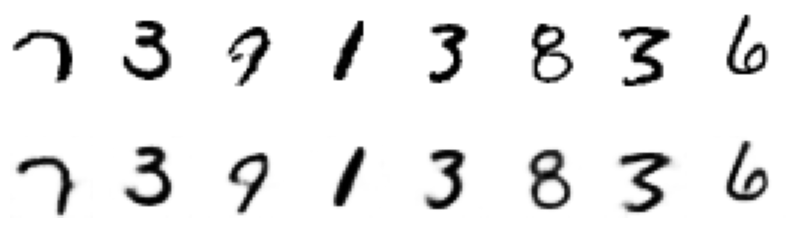

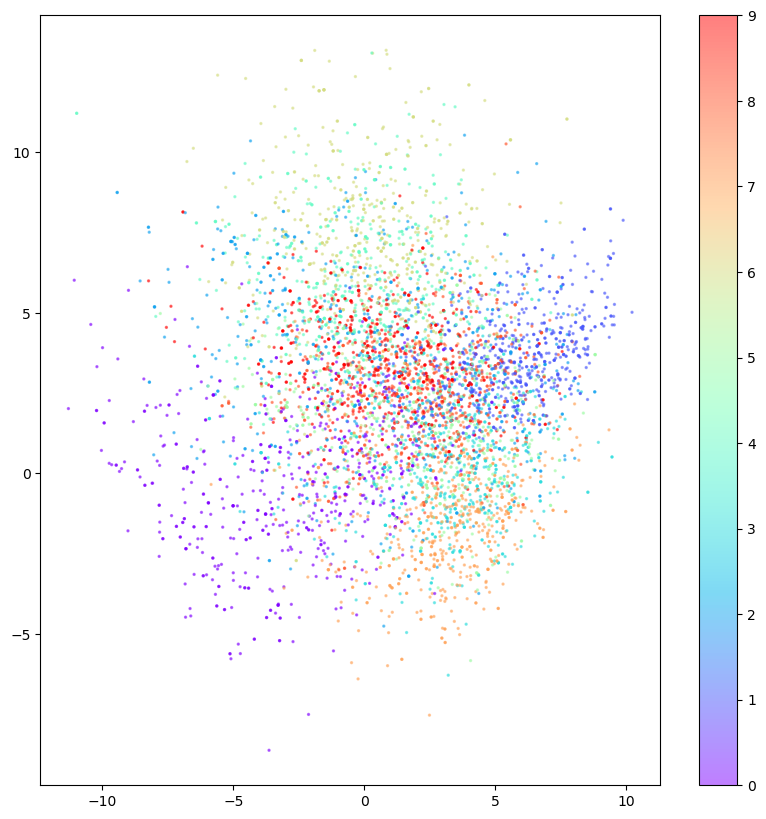

In [34]:
if __name__ == "__main__":
    autoencoder = VAE.load("model")
    x_train, y_train, x_test, y_test = load_mnist()

    num_sample_images_to_show = 8
    sample_images, _ = select_images(x_test, y_test, num_sample_images_to_show)
    reconstructed_images, _ = autoencoder.reconstruct(sample_images)
    plot_reconstructed_images(sample_images, reconstructed_images)

    num_images = 6000
    sample_images, sample_labels = select_images(x_test, y_test, num_images)
    _, latent_representations = autoencoder.reconstruct(sample_images)
    plot_images_encoded_in_latent_space(latent_representations, sample_labels)